# Analyzing Robustness in Random and Small World Graph Models

When thinking about the robustness in a graph, we are analyzing properties of a graph as you randomly remove nodes or target nodes that have the highest degree within that graph. Some of the properties we are looking at are the largest cluster size relative to the number of nodes in the graph and as the graph splits into isolated clusters, looking at the average size of those isolated clusters. Another property we are investigating is the average shortest path between any two nodes in the graph.

By comparing different graph models and these properties, we can determine which types of models would be best for different applications. For example, in the design of an electrical grid, maintaining a connected graph representing the electrical grid is likely more important than the shortest path length between any two nodes. Alternatively, in the design of a road network, the shortest path between any two nodes representing cities or locations in a city is probably an important consideration, especially if the edges are weighted and there can be an analysis of how long it would take to traverse from one node to another.

In our exploration, we will look at Erdos-Renyi random graphs, Watts-Strogatz small world graphs, and a few physical models that we have found already modeled to investigate their response to random attacks on nodes and edges as well as targeted attacks on nodes and edges in order to see how these different applications hold under an attack or in the event of failures.

## Importing Packages and Downloading Tools

In [15]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import seaborn as sns
import random
import time

In [16]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ThinkComplexity2/raw/master/notebooks/utils.py')

## Helper Functions

These functions are used to find properties of the graphs that we are analyzing

In [173]:
def read_graph(filename):
    """Reads a graph from a .txt file"""
    G = nx.Graph()
    array = np.loadtxt(filename, dtype=int)
    G.add_edges_from(array)
    return G


def sample_path_lengths(G, nodes=None, trials=1000):
    """Choose random pairs of nodes and compute the path length between them.

    G: Graph
    nodes: list of nodes to choose from
    trials: number of pairs to choose

    returns: list of path lengths
    """
    if nodes is None:
        nodes = list(G)
    else:
        nodes = list(nodes)
    
    pairs = np.random.choice(nodes, (trials, 2))
    lengths = []
    for pair in pairs:
        try:
            path = nx.shortest_path_length(G, *pair)
            lengths.append(path)
        except:
            pass
    return lengths


def average_shortest_path(G):
    """Returns the average shortest path length between two random nodes over n trials
    """
    return np.mean(sample_path_lengths(G))


def clusters(G):
    """Finds the largest connected cluster in the graph, G, and the average size of all isolated clusters
    returns a tuple of (relative largest cluster size, average isolated cluster size)
    """
    largest = len(max(nx.connected_components(G), key=len))
    sizes = [len(i) for i in nx.connected_components(G)]
    sizes.remove(largest)
    average_isolated = np.mean(sizes) if sizes else 0
    return largest/len(G.nodes()), average_isolated


def run_attack(G, attack, step=.01, max_removal=0.8):
    """ Runs as attack (either targeted or random) on a graph then returns properties that are useful
    for analysis.
    
    G: Graph to attack
    attack: type of attack function to test
    step: what fraction (of nodes/edges) to remove on every step
    max_removal: the maximum fraction to stop at
    
    Returns a tuple of lists:
    (fraction steps, relative largest size, average isolated size, average shortest path)
    """
    G = G.copy()
    k = int(max_removal/step)
    f_step = np.linspace(1,k,k)*step
    
    rel_largest, avg_isolated, avg_path = [], [], []
    n = len(G)

    t0 = time.time()
    for i in f_step:
        # remove nodes
        attack(G, int(step*n))

        # calculate cluster properties
        rel_lg, avg_iso = clusters(G)

        # add properties
        rel_largest.append(rel_lg)
        avg_isolated.append(avg_iso)
        if (rel_lg >= 1.0):
            avg_path.append(average_shortest_path(G))
            
    print("time: ", time.time() - t0)
    return (f_step, rel_largest, avg_isolated, avg_path)
    

def plot_comparison(properties1, properties2, name1, name2, save_name=None):
    """Plots the properties of an attack compared to another graph
    """
    (f_step1, rel_largest1, avg_isolated1, avg_path1) = properties1
    (f_step2, rel_largest2, avg_isolated2, avg_path2) = properties2
    
    # error catching
    if (len(f_step1) is not len(f_step2)):
        print('different fractions of deletion or steps')
        return
    
    f_step = f_step1
    
    plt.figure(figsize=(15,10))
    
    plt.subplot(2,2,1)
    plt.plot(f_step, rel_largest1)
    plt.plot(f_step, rel_largest2)
    plt.legend([name1, name2])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Largest Cluster Size / Number of Nodes")
    plt.title("Relative Size of Largest Cluster")

    plt.subplot(2,2,2)
    plt.plot(f_step, avg_isolated1)
    plt.plot(f_step, avg_isolated2)
    plt.legend([name1, name2])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Isolated Cluster Size")
    plt.title("Size of Average Isolated Cluster")
    
    plt.subplot(2,2,3)
    plt.plot(f_step[:len(avg_path1)], avg_path1)
    plt.plot(f_step[:len(avg_path2)], avg_path2)
    plt.legend([name1, name2])
    plt.xlabel("Fraction of Nodes Removed")
    plt.ylabel("Average Shortest Path Length")
    plt.title("Average Shortest Path Between 2 Nodes")
    
    if (save_name):
        plt.savefig('figures/' + save_name + '.jpg')
    plt.show()

## Implementing a Random Node Attack

In [153]:
def random_attack(G, k):
    """Returns a graph with k nodes removed at random"""
    nodes_removed = random.sample(list(G.nodes),k=k)
    G.remove_nodes_from(nodes_removed)

## Testing Random Node Attack on a WS Graph

average shortest length:  3.676
largest relative cluster:  1.0
average isolated cluster size:  0
number of nodes:  100


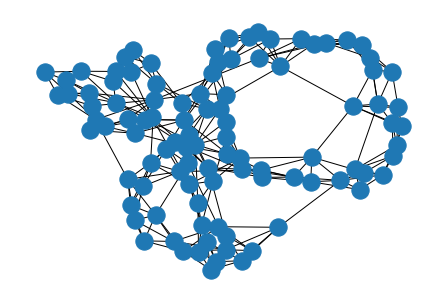

In [149]:
WS = nx.watts_strogatz_graph(100, 7, 0.1)
nx.draw(WS)
largest_cluster, avg_cluster = clusters(WS)

print("average shortest length: ", average_shortest_length(WS))
print("largest relative cluster: ", largest_cluster)
print("average isolated cluster size: ", avg_cluster)
print("number of nodes: ", len(WS.nodes()))

By removing 50 nodes from our original graph of 100 nodes we are testing a random attack where each node has a 50% chance of failing.

average shortest length:  8.092
largest relative cluster:  1.0
average isolated cluster size:  0
number of nodes:  50


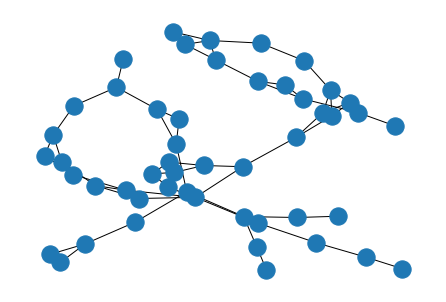

In [150]:
random_attack(WS, 50)
nx.draw(WS)
largest_cluster, avg_cluster = clusters(WS)

print("average shortest length: ", average_shortest_length(WS))
print("largest relative cluster: ", largest_cluster)
print("average isolated cluster size: ", avg_cluster)
print("number of nodes: ", len(WS.nodes()))

## Random Node Attack on Large Graphs

We want to replicate the results of the paper by running a random attack on random and scale-free graphs that reflect the properties of the graphs used by the authors.

time:  0.5793623924255371
time:  2.7642533779144287


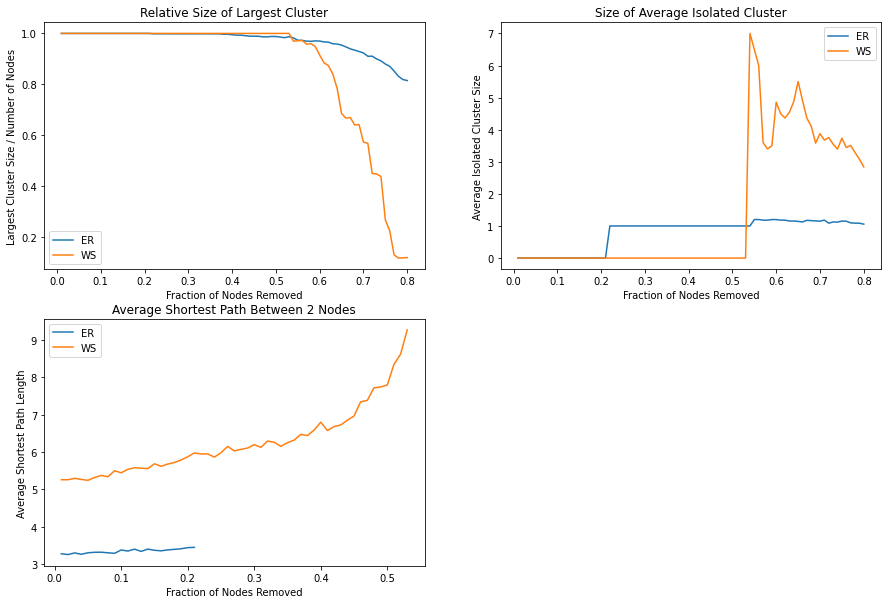

In [174]:
#ER paramters
n = 1000
m = 5*n

#WS parameters
k = int(2*m/n)
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

prop_er = run_attack(ER, random_attack)
prop_ws = run_attack(WS, random_attack)
plot_comparison(prop_er, prop_ws, 'ER', 'WS', 'er_ws_random_attack')

## Conducting Targeted Attacks

In [134]:
def target_node_attack(G, k):
    """
    Targets k nodes with the most connections, then removes those node.
    G: Graph to target
    """
    for i in range(k):
        degrees = dict(G.degree())
        target = max(degrees, key=degrees.get)
        G.remove_node(target)

### Targeted Attacks on Large Graphs


time:  0.5960149765014648
time:  3.943235158920288


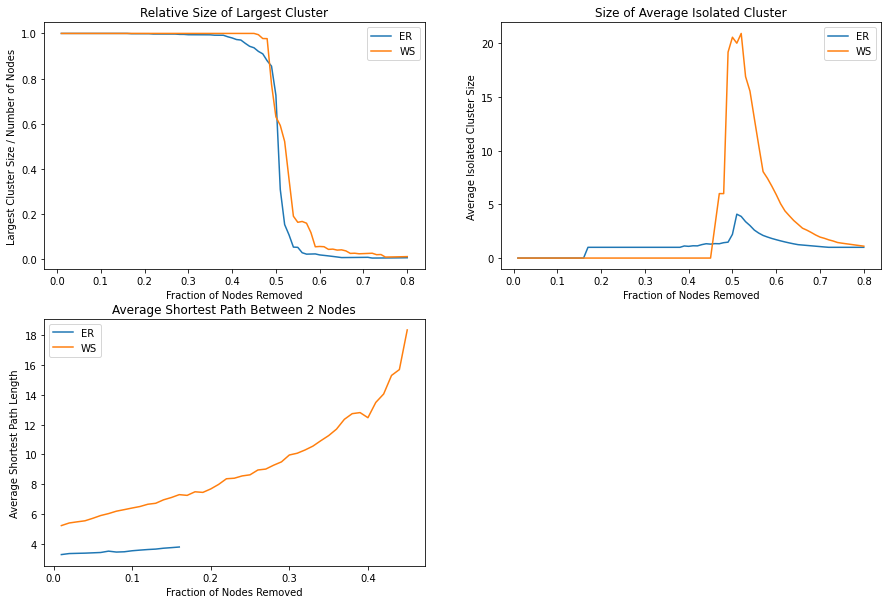

In [175]:
#ER paramters
n = 1000
m = 5*n

#WS parameters
k = int(2*m/n)
p_WS = 0.05

ER = nx.gnm_random_graph(n, m)
WS = nx.watts_strogatz_graph(n, k, p_WS)

prop_er = run_attack(ER, target_node_attack)
prop_ws = run_attack(WS, target_node_attack)
plot_comparison(prop_er, prop_ws, 'ER', 'WS', 'er_ws_target_attack')

## Testing Facebook Graph

The facebook graph should reflect a real small-world graph example. We can compare the facebook data to a random graph of similar size.

Graph with 4039 nodes and 88234 edges
time:  6.4525580406188965
time:  3.0678703784942627


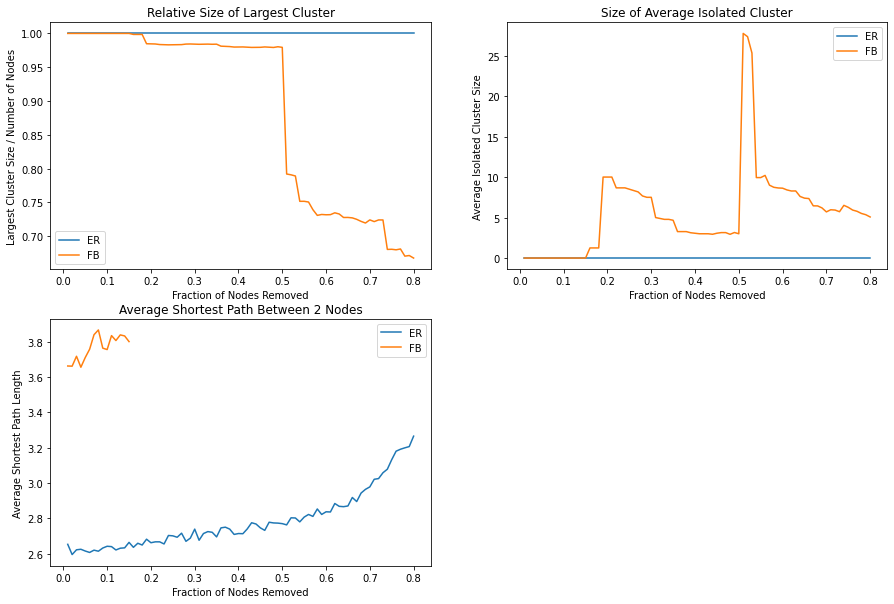

In [177]:
download('https://snap.stanford.edu/data/facebook_combined.txt.gz')
fb = read_graph('facebook_combined.txt.gz')

n = len(fb)
m = len(fb.edges())
ER =  nx.gnm_random_graph(n, m)
print(ER)

prop_fb = run_attack(fb, random_attack)
prop_er = run_attack(ER, random_attack)
plot_comparison(prop_er, prop_fb, 'ER', 'FB', 'er_facebook_random_attack')

Graph with 4039 nodes and 88234 edges
time:  3.664104700088501
time:  5.549793004989624


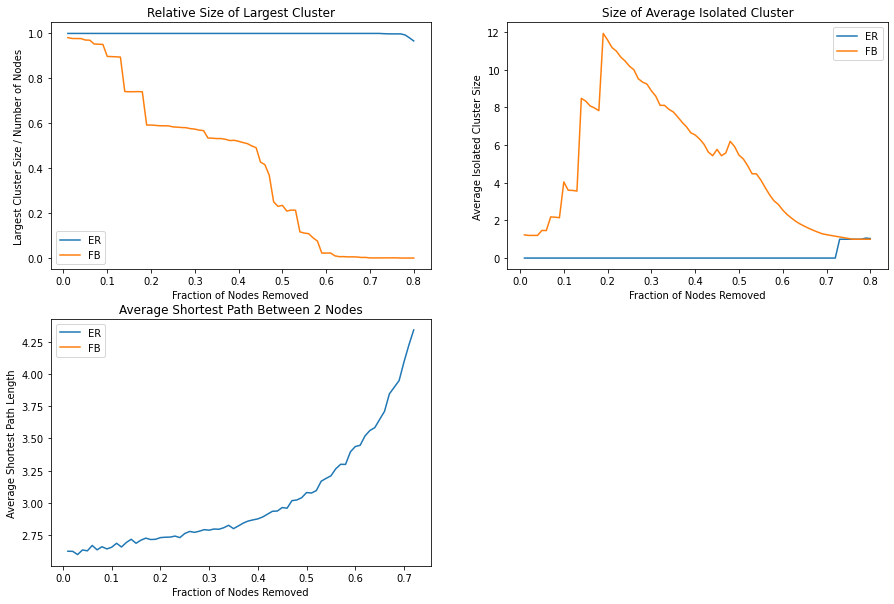

In [178]:
n = len(fb)
m = len(fb.edges())
ER =  nx.gnm_random_graph(n, m)
print(ER)

prop_fb = run_attack(fb, target_node_attack)
prop_er = run_attack(ER, target_node_attack)
plot_comparison(prop_er, prop_fb, 'ER', 'FB', 'er_facebook_target_attack')

## Loading the Electrical Grid Graph

This graph is a model of the Western United States electrical grid. You can find more information [here](http://konect.cc/networks/opsahl-powergrid/).

In [169]:
electrical_grid = read_graph('opsahl-powergrid/out.opsahl-powergrid')
print(electrical_grid)

Graph with 4941 nodes and 6594 edges


In [ ]:
def plot_one():
    pass